Min date: 2006-12-16 17:24:00
Max date: 2010-11-26 21:02:00


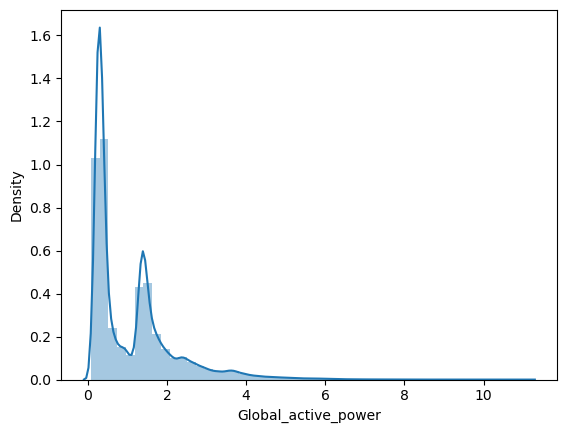

Kurtosis: 4.218671866132123
Skewness: 1.7862320846320818
Results of Dickey-Fuller test:
Test Statistic               -3.684228
p-value                       0.004341
# Lags Used                  22.000000
No of Observations Used    1410.000000
Critical Value (1%)          -3.434996
Critical Value (5%)          -2.863592
Critical Value (10%)         -2.567862
dtype: float64


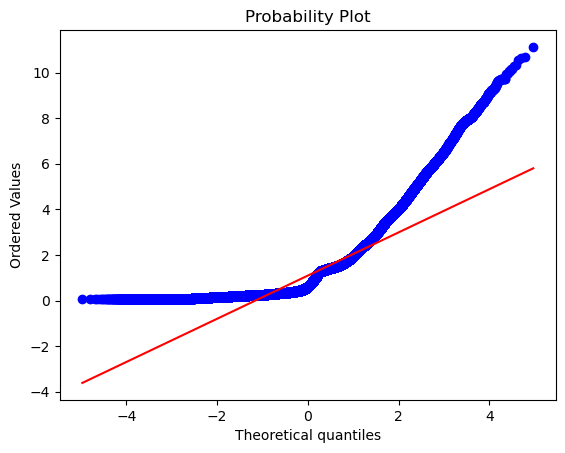

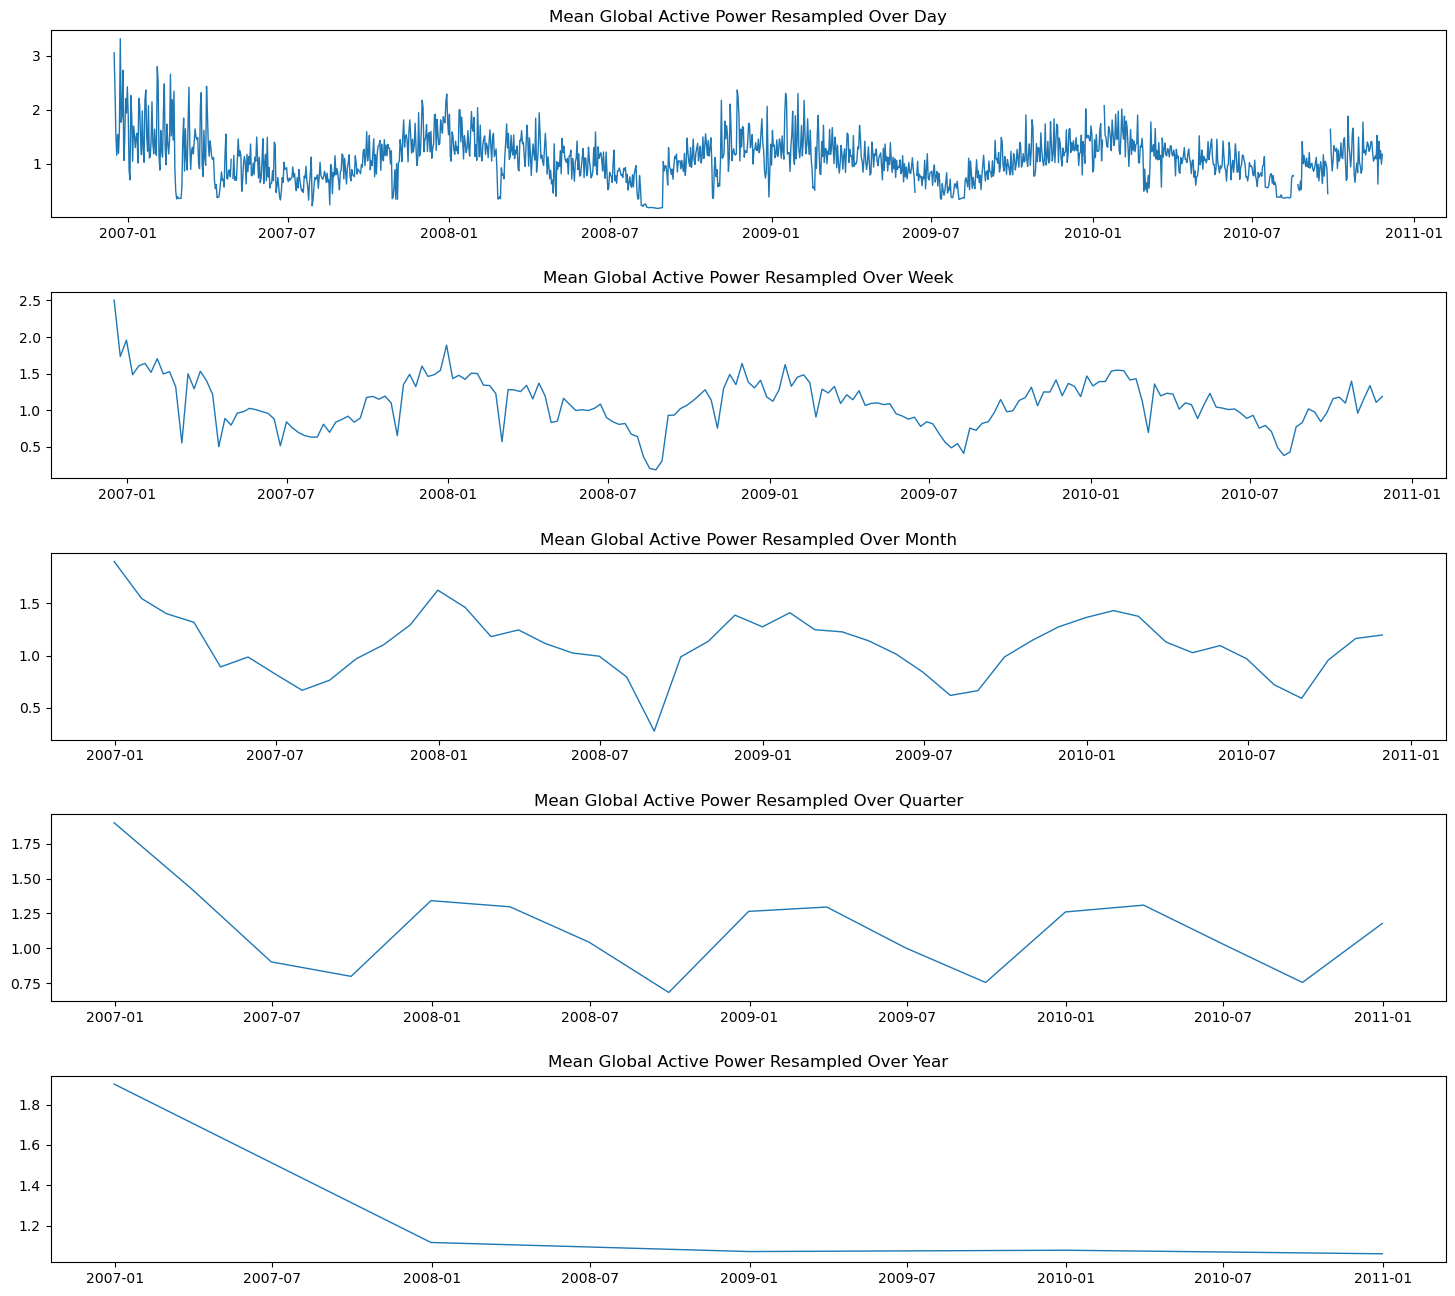

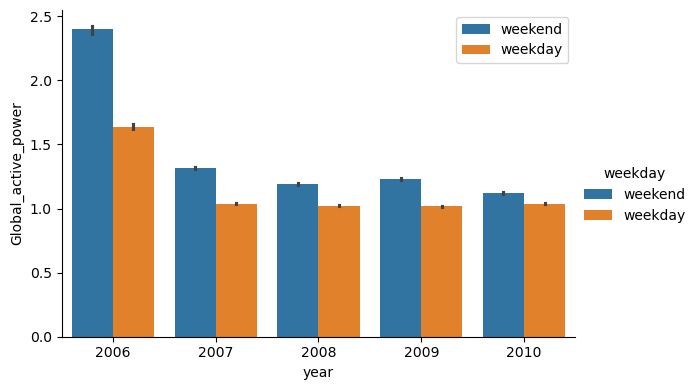

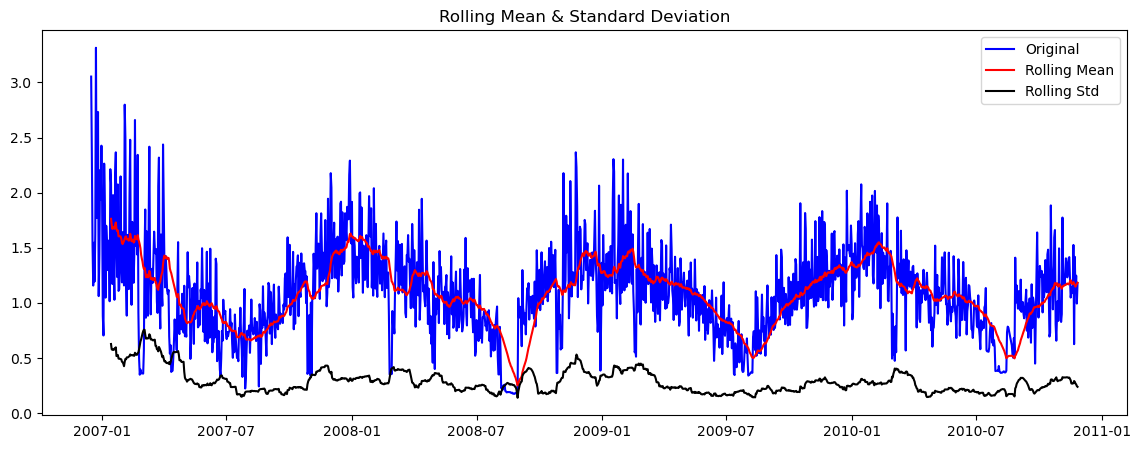

Train shape: (53342, 1)
Test shape: (15883, 1)
Epoch 1/20
3048/3048 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - loss: 0.0139
Epoch 2/20
3048/3048 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - loss: 0.0128
Epoch 3/20
3048/3048 ━━━━━━━━━━━━━━━━━━━━ 42s 9ms/step - loss: 0.0128
Epoch 4/20
3048/3048 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - loss: 0.0128
Epoch 5/20
3048/3048 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - loss: 0.0128
Epoch 6/20
3048/3048 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - loss: 0.0127
Epoch 7/20
3048/3048 ━━━━━━━━━━━━━━━━━━━━ 43s 9ms/step - loss: 0.0127
Epoch 8/20
3048/3048 ━━━━━━━━━━━━━━━━━━━━ 42s 9ms/step - loss: 0.0128
Epoch 9/20
3048/3048 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - loss: 0.0127
Epoch 10/20
3048/3048 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 0.0127
Epoch 11/20
3048/3048 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - loss: 0.0127
Epoch 12/20
3048/3048 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - loss: 0.0127
Epoch 13/20
3048/3048 ━━━━━━━━━━━━━━━━━━━━ 42s 9ms/step - loss: 0.0128
Epoch 14/20
3048/3048 ━━━━━━━━━━━━━━━━━

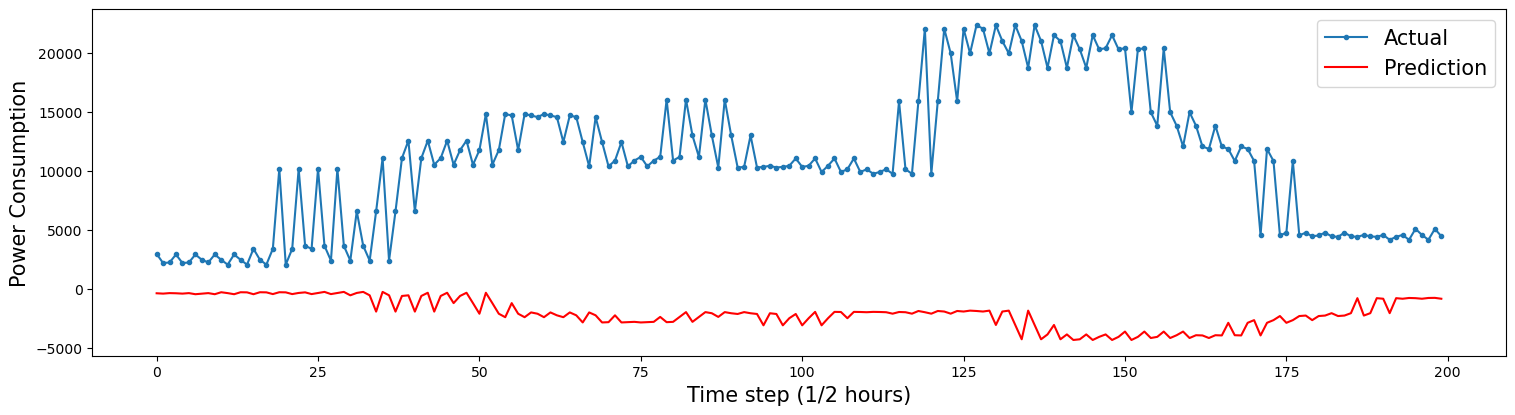

In [102]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings

# Configure settings
%matplotlib inline
warnings.filterwarnings('ignore')

# Load the dataset
file_path = r'C:\Users\GIGABYTE\Desktop\challenge ias\household_power_consumption.txt'  # Update with the actual file path
df = pd.read_csv(file_path, sep=';')
df.head()

# Check for missing values
df.isnull().sum()

# Merge date and time into one variable
df['new_date'] = df['Date'] + ' ' + df['Time']
df['new_date'] = pd.to_datetime(df['new_date'])
df1 = df[['new_date', 'Global_active_power']]
df1['Global_active_power'] = pd.to_numeric(df1['Global_active_power'], errors='coerce')

# Display date range
print('Min date:', df1['new_date'].min())
print('Max date:', df1['new_date'].max())

# Plot distribution of Global_active_power
sb.distplot(df1['Global_active_power'])
plt.show()

# Handle missing values
df1 = df1[df1['Global_active_power'].notnull()]
print('Kurtosis:', stats.kurtosis(df1['Global_active_power']))
print('Skewness:', stats.skew(df1['Global_active_power']))

# Probability plot
stats.probplot(df1['Global_active_power'], plot=plt)

# Descriptive statistics
df1.describe().T

# Set index and drop redundant columns
df1.set_index(df1['new_date'], inplace=True)
df2 = df1.drop('new_date', axis=1)

# Resampling and plotting
fig = plt.figure(figsize=(18, 16))
fig.subplots_adjust(hspace=.4)
for i, (title, freq) in enumerate(
    [
        ("Day", 'D'), 
        ("Week", 'W'), 
        ("Month", 'M'), 
        ("Quarter", 'Q'), 
        ("Year", 'A')
    ], start=1
):
    ax = fig.add_subplot(5, 1, i)
    ax.plot(df2['Global_active_power'].resample(freq).mean(), linewidth=1)
    ax.set_title(f'Mean Global Active Power Resampled Over {title}')
    ax.tick_params(axis='both', which='major')

# Create additional features
df3 = df[['new_date', 'Global_active_power']]
df3['Global_active_power'] = pd.to_numeric(df3['Global_active_power'], errors='coerce')
df3 = df3[df3['Global_active_power'].notnull()]
df3['day'] = df3['new_date'].dt.dayofweek
df3['year'] = df3['new_date'].dt.year
df3['weekday'] = df3['day'].apply(lambda x: 'weekday' if x < 5 else 'weekend')

# Categorical plot
sb.catplot(
    x='year',
    y='Global_active_power',
    hue='weekday',
    data=df3,
    kind='bar',
    height=4,
    aspect=1.5
)
plt.legend(loc='upper right')

# Dickey-Fuller test
df4 = df2.resample('D').mean()
df5 = df4[df4['Global_active_power'].notnull()]
print('Results of Dickey-Fuller test:')
dftest = adfuller(df5['Global_active_power'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '# Lags Used', 'No of Observations Used'])
for key, value in dftest[4].items():
    dfoutput[f'Critical Value ({key})'] = value
print(dfoutput)

# Plot rolling statistics
rolling_mean = df5.rolling(window=30).mean()
rolling_std = df5.rolling(window=30).std()
plt.figure(figsize=(14, 5))
plt.plot(df5, color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

# Split data into training and testing sets
dfx = df2.resample('30min').sum()
train = dfx['2006-12-16':'2009-12-31']
test = dfx['2009-12-31':]
print('Train shape:', train.shape)
print('Test shape:', test.shape)

# Prepare training data
train = np.array(train)
X_train, y_train = [], []
for i in range(4, len(train) - 4):
    X_train.append(train[i-4:i])
    y_train.append(train[i:i+4])
X_train, y_train = np.array(X_train), np.array(y_train)
# Reshape to 2D for scaling
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
y_train_reshaped = y_train.reshape(-1, y_train.shape[-1])
# Scale and reshape data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_reshaped)
y_train = scaler.fit_transform(y_train_reshaped)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# Reshape back to original 3D shape
X_train = X_train.reshape(X_train.shape)
y_train = y_train.reshape(y_train.shape)
# Build and train the LSTM model
lstm = Sequential([
    LSTM(units=200, activation='relu', input_shape=(4, 1)),
    Dropout(0.2),
    Dense(4)
])
lstm.compile(loss='mse', optimizer='adam')
lstm.fit(X_train, y_train, epochs=20, batch_size=70)

# Test the model
test = np.array(test)
X_test, y_test = [], []
for i in range(4, len(test) - 4):
    X_test.append(test[i-4:i])
    y_test.append(test[i:i+4])
X_test, y_test = np.array(X_test), np.array(y_test)
# Reshape to 2D for scaling
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])
X_test = scaler.transform(X_test_reshaped).reshape(X_test.shape[0], X_test.shape[1], 1)
y_pred = scaler.inverse_transform(lstm.predict(X_test_reshaped))
y_act = scaler.inverse_transform(y_test_reshaped)
# Reshape back to original 3D shape
X_test = X_test.reshape(X_test.shape)
y_test = y_test.reshape(y_test.shape)
# Plot predictions
plt.figure(figsize=(15, 4))
plt.plot(y_act[:200, 0], marker='.', label="Actual")
plt.plot(y_pred[1:201, 0], 'r', label="Prediction")
plt.tight_layout()
plt.ylabel('Power Consumption', size=15)
plt.xlabel('Time step (1/2 hours)', size=15)
plt.legend(fontsize=15)
plt.show()

In [104]:

# Save the model in the recommended .keras format
lstm.save(r'C:\Users\GIGABYTE\Desktop\challenge ias\lstm_model.keras')


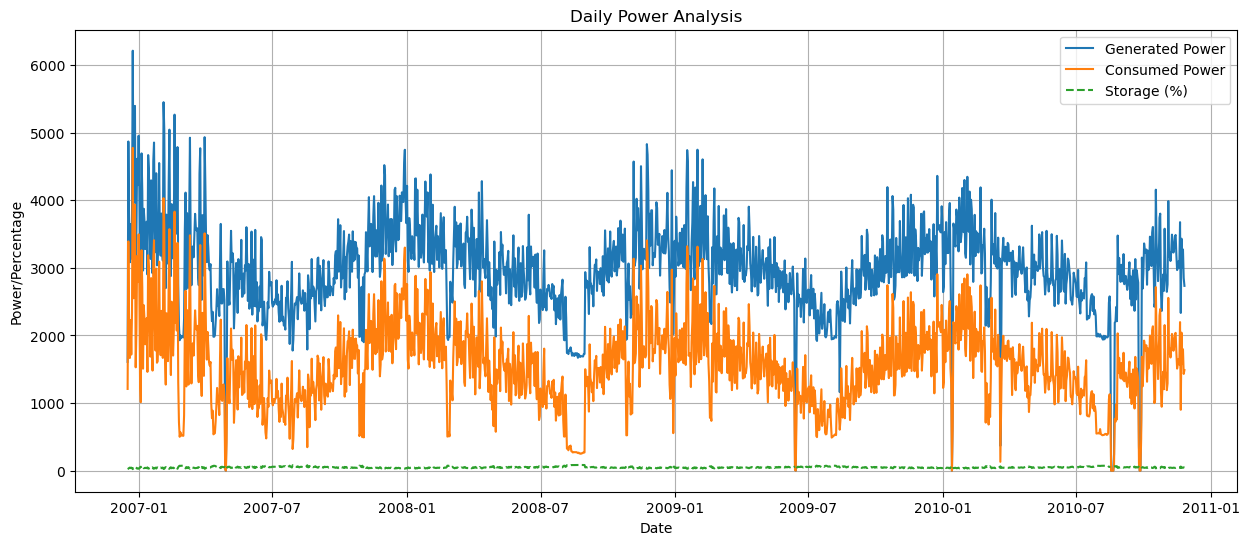

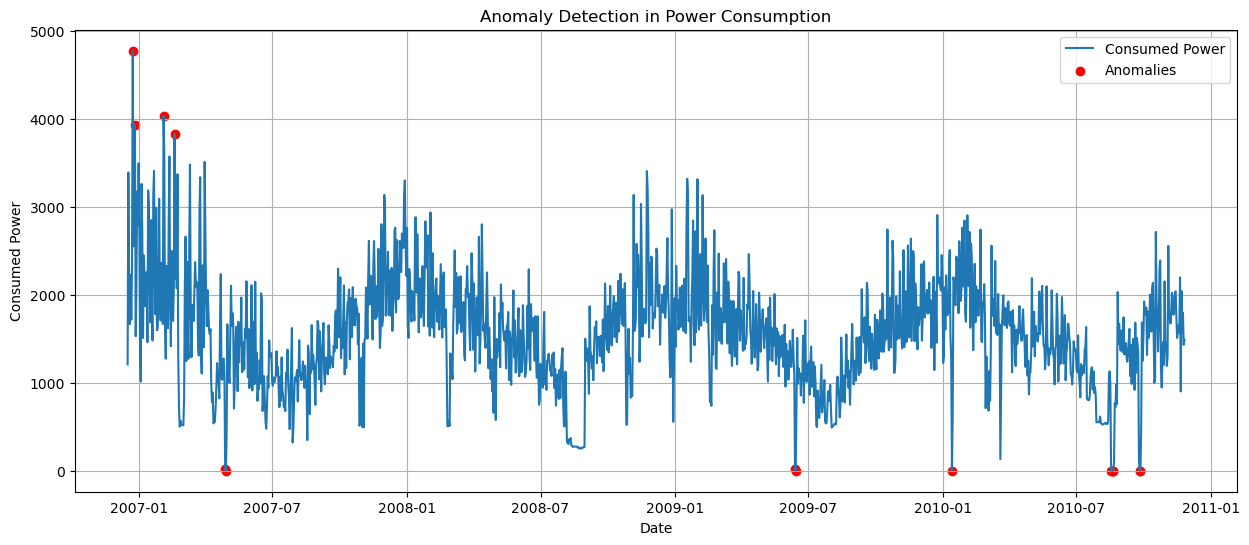

In [98]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Load the dataset
file_path = r'C:\Users\GIGABYTE\Desktop\challenge ias\household_power_consumption.txt'  # Update with the correct path
df = pd.read_csv(file_path, sep=';')

# Parse and preprocess data
df['new_date'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], errors='coerce')
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')

# Filter out rows with missing data
df.dropna(subset=['new_date', 'Global_active_power'], inplace=True)

# Simulate daily power generation
np.random.seed(42)  # For reproducibility
df['Generated_power'] = df['Global_active_power'] + np.random.normal(1.0, 0.5, len(df))

# Resample data for daily aggregations
df.set_index('new_date', inplace=True)

# Select numeric columns for aggregation
numeric_cols = df.select_dtypes(include=[np.number]).columns
daily_data = df[numeric_cols].resample('D').sum()

# Calculate storage percentage
daily_data['Storage_Percentage'] = ((daily_data['Generated_power'] - daily_data['Global_active_power']) /
                                    daily_data['Generated_power']) * 100

# Anomaly Detection
model = IsolationForest(contamination=0.01, random_state=42)
daily_data['Anomaly'] = model.fit_predict(daily_data[['Global_active_power', 'Generated_power']])

# Plot daily power generation, consumption, and storage
plt.figure(figsize=(15, 6))
plt.plot(daily_data.index, daily_data['Generated_power'], label='Generated Power')
plt.plot(daily_data.index, daily_data['Global_active_power'], label='Consumed Power')
plt.plot(daily_data.index, daily_data['Storage_Percentage'], label='Storage (%)', linestyle='--')
plt.legend()
plt.title('Daily Power Analysis')
plt.xlabel('Date')
plt.ylabel('Power/Percentage')
plt.grid()
plt.show()

# Highlight anomalies in power consumption
anomalies = daily_data[daily_data['Anomaly'] == -1]
plt.figure(figsize=(15, 6))
plt.plot(daily_data.index, daily_data['Global_active_power'], label='Consumed Power')
plt.scatter(anomalies.index, anomalies['Global_active_power'], color='red', label='Anomalies')
plt.legend()
plt.title('Anomaly Detection in Power Consumption')
plt.xlabel('Date')
plt.ylabel('Consumed Power')
plt.grid()
plt.show()
